<a href="https://colab.research.google.com/github/rpast/t-sunset/blob/main/tsunset_finetuning_poc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Tue Jan 24 20:33:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    53W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 81.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 108.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 22.8 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
## Import section ##
####################
import os
import time
import datetime
from google.colab import drive

import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
import plotly.express as px 

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    print("no CUDA!")

In [6]:
#load dataset
dset = pd.read_csv('./drive/MyDrive/datasets/the-office_lines.csv')

# Preprocess
dset_n = (dset
          [['Character', 'Line', 'Season']].copy()
)

# form inputs feature
def form_inputs(df_):
    """Form final data series out of dataframe object
    """
    df_['inputs'] = "CHARACTER: " + df_['Character'] + "; LINE: " + df_['Line']
    return df_['inputs']



In [7]:
# Explore dataset

# How many characters do we have in the dialogs?
dset_n['Character'].value_counts().shape

(780,)

In [8]:
# What proportion of all dialogs occupies Top20
top25 = dset_n['Character'].value_counts()[:25].index
dset_n['top25'] = dset_n['Character'].apply(lambda x: x in top25)
px.histogram(dset_n, x='Character', color='top25').update_xaxes(categoryorder='total descending')

In [9]:
# 3. See dialogues distribution by seasons
px.histogram(dset_n, x='Season')

In [10]:
# Let's train GPT on first 3 seasons
dset_n_prun = (dset_n
               [dset_n['Season']<=3]
               .reset_index()
)

# form final data series out of the dataframe
dset_main = form_inputs(dset_n_prun)
print(dset_main.shape)
dset_main.sample(3)

(16876,)


4615     CHARACTER: Michael; LINE:  I don’t understand-...
14288     CHARACTER: Jan; LINE:  What’s this over the “i”?
13018    CHARACTER: Creed; LINE:  I don’t know what to ...
Name: inputs, dtype: object

In [11]:
doc_lengths = []

for line in dset_main:
    # get rough token count distribution
    tokens = nltk.word_tokenize(line)
    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

px.histogram(doc_lengths)

In [12]:
np.average(doc_lengths)

21.430137473334913

In [13]:
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained(
    'gpt2', 
    bos_token='<|startoftext|>', 
    eos_token='<|endoftext|>', 
    pad_token='<|pad|>'
)

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [14]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


In [15]:
batch_size = 4

In [16]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=1024):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

        encodings_dict = tokenizer(
            '<|startoftext|>'+ txt + '<|endoftext|>', 
            truncation=True, 
            max_length=max_length, 
            padding="max_length"
        )

        self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
        self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

In [17]:
dataset = GPT2Dataset(
    dset_main, 
    tokenizer, 
    max_length=1024
)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size]) # << TRAIN DSET

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

15,188 training samples
1,688 validation samples


In [18]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [19]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

Downloading:   0%|          | 0.00/548M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [20]:
# some parameters I cooked up that work reasonably well

epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [21]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning:

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning



In [22]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [23]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [24]:
total_t0 = time.time()

training_stats = []

model = model.to(device)


for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  3,797. Loss: 0.1720961332321167.   Elapsed: 0:00:34.
0:  bipartisanCHARACTER: Jim; LINE:  Michael and Michael; LINE:  you do not mean; LINE:.seseses.w.t.t lot… Michael, Michael.’.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  3,797. Loss: 0.16992680728435516.   Elapsed: 0:01:06.
0:  increasingCHARACTER: Jim; LINE:  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  3,797. Loss: 0.15388354659080505.   Elapsed: 0:01:38.
0: dayCHARACTER: Michael; LINE:   [holds,holds it in. It is not


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  3,797. Loss: 0.1113915890455246.   Elapsed: 0:02:12.
0:  HangCHARACTER: Phyllis; LINE:  [underlying boxes, clapping] Hey, you “re supposed to “t be having this conversation about, what’s been going on in your life?   


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  3,797. Loss: 0.1448700726032257.   Elapsed: 0:02:44.
0:  foodsCHARACTER: Dwight; LINE:  [to make her feel better]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  3,797. Loss: 0.023112859576940536.   Elapsed: 0:03:15.
0:  trailCHARACTER: Angela; LINE:  Hey everyone. We’re going to be talking about this’s.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  3,797. Loss: 0.15929876267910004.   Elapsed: 0:03:47.
0: intendCHARACTER: Dwight; LINE:  You want a cake?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  3,797. Loss: 0.07678569108247757.   Elapsed: 0:04:18.
0:  surroundCHARACTER: Michael; LINE:  You know, whatever.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  3,797. Loss: 0.06890499591827393.   Elapsed: 0:04:50.
0:  reflexCHARACTER: Ben Franklin; LINE:  You know what? You know what? I didn’t get one. I didn’t get one! You know what? I just don’t get one. What the hell? What did you do? There’s the suggestion that I am not giving my daughter a raise. I feel like I’m giving her a raise, you know what I mean? [Pffish and nods]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  3,797. Loss: 0.0752788782119751.   Elapsed: 0:05:22.
0:  displayCHARACTER: Ryan; LINE:  Yes. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  3,797. Loss: 0.03413427993655205.   Elapsed: 0:05:54.
0:  pastorCHARACTER: Roy; LINE:  That’s it.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  3,797. Loss: 0.033908259123563766.   Elapsed: 0:06:25.
0:  illicitCHARACTER: Michael; LINE:  OK. [Jim stares down the aisle and sees a cake] Sorry. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  3,797. Loss: 0.04101147875189781.   Elapsed: 0:06:57.
0:  LiberationCHARACTER: Kevin; LINE:  Oh, I like you.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  3,797. Loss: 0.10758507251739502.   Elapsed: 0:07:28.
0:  Nam [. LINE? ; ;. you. You I: to a that; you  the; of at!;. a are me…??.. you do  I. for You you do. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  3,797. Loss: 0.1319168210029602.   Elapsed: 0:08:00.
0: IONCHARACTER: I�! 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  3,797. Loss: 0.0643208920955658.   Elapsed: 0:08:32.
0:  glimpseCHARACTER: Michael; LINE. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  3,797. Loss: 0.06904185563325882.   Elapsed: 0:09:03.
0:  LaureCHARACTER: Pam LINE:  You the what I is the: ;  a, �? ;’���.   you


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  3,797. Loss: 0.14726215600967407.   Elapsed: 0:09:35.
0: ismCHARACTER: Dwight; LINE] [ You can you  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  3,797. Loss: 0.03401068225502968.   Elapsed: 0:10:06.
0: ounCHARACTER: Jan; LINE:  That’s [ [ 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  3,797. Loss: 0.10144487768411636.   Elapsed: 0:10:38.
0:  electionCHARACTER: Pam; LINE:  Yeah,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  3,797. Loss: 0.11169448494911194.   Elapsed: 0:11:09.
0:  crazyCHARACTER: Ryan; LINE:  Uh, I’s a way of an] It…


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  3,797. Loss: 0.054222892969846725.   Elapsed: 0:11:41.
0:  benchCHARACTER: Jim; LINE:  Ok.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  3,797. Loss: 0.029529109597206116.   Elapsed: 0:12:12.
0:  incorporatedCHARACTER: Dwight; LINE:  [sing and this is an hour. So, yeah. [laughs] But… “�] She, do I’s just you don it to be.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  3,797. Loss: 0.06590891629457474.   Elapsed: 0:12:44.
0: PeterCHARACTER: Michael; LINE:  Yeah, I have an offer you all your desk that for a break to come…


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  3,797. Loss: 0.05007188394665718.   Elapsed: 0:13:16.
0: uringCHARACTER: Dwight; LINE:  Okay. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  3,797. Loss: 0.03892551735043526.   Elapsed: 0:13:47.
0:  reproductiveCHARACTER: Dwight; LINE:  What?  Let us? “, what do you know for a man, this?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  3,797. Loss: 0.030721578747034073.   Elapsed: 0:14:19.
0:  zoneCHARACTER: Pam; LINE:  Yeah, no. That’t”’m so exciting. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  3,797. Loss: 0.07546507567167282.   Elapsed: 0:14:50.
0:  commitsCHARACTER: Ryan; LINE:  I have got all the money. You’ll be really special. I have got to help’s in the middle of my condo.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  3,797. Loss: 0.07114799320697784.   Elapsed: 0:15:22.
0:  ironyCHARACTER: Jim; LINE:  Oh. Oh, please! 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  3,797. Loss: 0.3459378778934479.   Elapsed: 0:15:54.
0:  SahCHARACTER: Michael; LINE:  [takes] What does Jim’s take?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  3,797. Loss: 0.08670828491449356.   Elapsed: 0:16:25.
0:  BryanCHARACTER: Ryan; LINE:  That’s good. I think that is not a good idea. I am not talking. That’s not a good idea.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  3,797. Loss: 0.09971914440393448.   Elapsed: 0:16:57.
0:  spiritsCHARACTER: Dwight; LINE:  Actually, you do! You get the job done.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  3,797. Loss: 0.03260534629225731.   Elapsed: 0:17:29.
0:  seesCHARACTER: Stanley; LINE:  Uh, good.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  3,797. Loss: 0.0696706473827362.   Elapsed: 0:18:00.
0:  hungryCHARACTER: Angela; LINE:  Well, you could just…  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  3,797. Loss: 0.05886958912014961.   Elapsed: 0:18:32.
0:  PTCHARACTER: Karen; LINE:  So there’s a few more people in there. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  3,797. Loss: 0.0472983755171299.   Elapsed: 0:19:03.
0: üCHARACTER: Jan; LINE:  Yeah, we are still trying to figure out how to get the party started.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  3,797. Loss: 0.0497395396232605.   Elapsed: 0:19:35.
0: ruceCHARACTER: Michael; LINE:  Come on, Michael.  

  Average training loss: 0.13
  Training epoch took: 0:20:05

Running Validation...
  Validation Loss: 0.06
  Validation took: 0:00:42

======== Epoch 2 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  3,797. Loss: 0.08308152854442596.   Elapsed: 0:00:31.
0:  derivativesCHARACTER: Andy; LINE:  [in the background] Oh, it was in the background.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  3,797. Loss: 0.019290106371045113.   Elapsed: 0:01:03.
0: CHARACTER: Dwight; LINE:  No, I didn’t…


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  3,797. Loss: 0.044658269733190536.   Elapsed: 0:01:35.
0:  rememberingCHARACTER: Michael; LINE:  Okay. I don’t know.  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  3,797. Loss: 0.0381561741232872.   Elapsed: 0:02:06.
0:  SourcesCHARACTER: Michael; LINE:  Do you wanna hear about this? 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  3,797. Loss: 0.06872963160276413.   Elapsed: 0:02:38.
0: emsCHARACTER: Dwight; LINE:  Good.    


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  3,797. Loss: 0.018281083554029465.   Elapsed: 0:03:09.
0: tzCHARACTER: Michael; LINE:  That’s a sign of good business… that’s all we’re getting.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  3,797. Loss: 0.05572329834103584.   Elapsed: 0:03:41.
0: maticCHARACTER: Meredith; LINE:  I don’t know if you guys think you deserve to be punished as much as you can.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  3,797. Loss: 0.06152413785457611.   Elapsed: 0:04:12.
0:  syndCHARACTER: Kelly; LINE:  Ah.  I, um, actually got some sort of money out of that.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  3,797. Loss: 0.03081837296485901.   Elapsed: 0:04:44.
0:  gamCHARACTER: Jim; LINE:  So… 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  3,797. Loss: 0.05415671318769455.   Elapsed: 0:05:15.
0:  injuryCHARACTER: Jim; LINE:  [singing] Come!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  3,797. Loss: 0.03525514528155327.   Elapsed: 0:05:47.
0: azaCHARACTER: Dwight; LINE:  Yeah. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  3,797. Loss: 0.02670934982597828.   Elapsed: 0:06:18.
0:  membraneCHARACTER: Toby; LINE:  We’re still discussing it.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  3,797. Loss: 0.06796377152204514.   Elapsed: 0:06:50.
0: ijingCHARACTER: Michael; LINE:  Ughhhhh.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  3,797. Loss: 0.051225073635578156.   Elapsed: 0:07:21.
0:  castCHARACTER: Michael; LINE:  Whoa whoa whoa whoa whoa whoa whoa whoa whoa whoa whoa whoa whoa whoa whoa whoa whoa whoa whoa whoa whoa whoaCHARACTER: Jimri AlaaabCHARACTER: DarrylACTER: Jan Vance Refrigeration Worker #::: Jim; LINE:  That makes the monkey


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  3,797. Loss: 0.07775825262069702.   Elapsed: 0:07:55.
0:  purchCHARACTER: Phyllis; LINE:  [starts a little to kiss Michael] [laughs] Yes!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  3,797. Loss: 0.0830298364162445.   Elapsed: 0:08:27.
0:  shouldersCHARACTER: Michael; LINE:  [Jim sees it and nods]  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  3,797. Loss: 0.05211322009563446.   Elapsed: 0:08:58.
0:  builtCHARACTER: Michael; LINE:  I saw him coming out.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  3,797. Loss: 0.034465957432985306.   Elapsed: 0:09:30.
0:  openlyCHARACTER: Pam; LINE:  Hey! [chanting] Michael, hello!  I was wondering if there was any way I could grab a piece of cake.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  3,797. Loss: 0.07139293849468231.   Elapsed: 0:10:01.
0:  haltedCHARACTER: Michael; LINE:  Yeah.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  3,797. Loss: 0.06533364951610565.   Elapsed: 0:10:33.
0:  NikCHARACTER: Michael; LINE:  No, I’m not going to do it.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  3,797. Loss: 0.058511558920145035.   Elapsed: 0:11:04.
0:  tinCHARACTER: Michael; LINE:  Alright, good luck!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  3,797. Loss: 0.03896643966436386.   Elapsed: 0:11:36.
0:  clinicalCHARACTER: Ryan; LINE:  It was, I didn’t feel that way.  I did.  And I was going to have fun. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  3,797. Loss: 0.05928591638803482.   Elapsed: 0:12:07.
0: lectionsCHARACTER: Creed; LINE:  We had a fight, and they win.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  3,797. Loss: 0.02173454500734806.   Elapsed: 0:12:39.
0: elsCHARACTER: Kevin; LINE:   I don’t think I’d miss that.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  3,797. Loss: 0.03598998859524727.   Elapsed: 0:13:10.
0: labCHARACTER: Pam; LINE:  OK, so where’s the fun?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  3,797. Loss: 0.02571393921971321.   Elapsed: 0:13:42.
0:  tripleCHARACTER: Dwight; LINE:  You know what, I would like to say I’m sorry you were so busy for this. I’m sorry.   


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  3,797. Loss: 0.08061745017766953.   Elapsed: 0:14:14.
0: 220CHARACTER: Michael; LINE:  [trying to get away] It’s a great plan. So what’s going on?  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  3,797. Loss: 0.05593090131878853.   Elapsed: 0:14:46.
0:  SeeCHARACTER: Michael; LINE:  Michael, come on in and get that party started, I have the party started. So get that party started, okay, come on.  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  3,797. Loss: 0.03476985916495323.   Elapsed: 0:15:17.
0: @@CHARACTER: Stanley; LINE:  All you are saying are the rules.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  3,797. Loss: 0.05661560967564583.   Elapsed: 0:15:49.
0:  hostCHARACTER: Jan; LINE:  Good.  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  3,797. Loss: 0.0436190702021122.   Elapsed: 0:16:20.
0: roleCHARACTER: Michael; LINE:  You want it from me?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  3,797. Loss: 0.021640000864863396.   Elapsed: 0:16:52.
0: iacCHARACTER: Michael; LINE:  Nice to see you, Dwight Schrute. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  3,797. Loss: 0.06161516159772873.   Elapsed: 0:17:23.
0:  LDCHARACTER: Jim; LINE:  Um, maybe you should talk to Michael.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  3,797. Loss: 0.06603885442018509.   Elapsed: 0:17:55.
0:  ListenCHARACTER: Karen; LINE:   Oh, thank you. How’s it going?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  3,797. Loss: 0.045158207416534424.   Elapsed: 0:18:26.
0:  dyCHARACTER: Dwight; LINE:  Michael, come on, come on, stop and stop. Stop and stop. Stop and stop, stop and stop. Stop and stop, stop and stop. Stop and stop, stop and stop, stop. Stop, stop. Stop. Stop. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  3,797. Loss: 0.05551055446267128.   Elapsed: 0:18:58.
0:  DomesticCHARACTER: Angela; LINE:  Okay.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  3,797. Loss: 0.04827282205224037.   Elapsed: 0:19:30.
0:  beneficiariesCHARACTER: Michael; LINE:  I thought it’s cool, but what’s that?

  Average training loss: 0.06
  Training epoch took: 0:20:00

Running Validation...
  Validation Loss: 0.06
  Validation took: 0:00:42

======== Epoch 3 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  3,797. Loss: 0.06780640780925751.   Elapsed: 0:00:31.
0:  TitleCHARACTER: Roy; LINE:  [on speaker phone] Michael Scott, who is the founder, a real name Darryl, on whom? [makes fake pretzel mouth] Jim Halpert.  Jim Halpert is the founder. Jim Halpert is a real name Darryl from Scranton.  Jim Halpert has a very nice story, [Jim Halpert turns on Jim Halpert] is that a fake.  A joke. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  3,797. Loss: 0.05683593079447746.   Elapsed: 0:01:04.
0:  μCHARACTER: Michael; LINE:  Well, you know what? I think you could have done that. I think you could.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  3,797. Loss: 0.03970986232161522.   Elapsed: 0:01:35.
0:  sellingCHARACTER: Jan; LINE:   That’s just all… the fun, all the fun that is.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  3,797. Loss: 0.03646404296159744.   Elapsed: 0:02:07.
0:  migrantCHARACTER: Michael; LINE:  I know, I know! I know… [exhales loudly] Hello, uh, this is Michael Scott.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  3,797. Loss: 0.03433145955204964.   Elapsed: 0:02:39.
0: ivelyCHARACTER: Ryan; LINE:  What does it say to a manager when a boss says to him, like, “boss’s son, like the manager’s son, like, “baby baby’s mother?”  “boss’s son, like the baby is an angel!” “boss’s son, like “t daddy’ me!” “boss’s son, like the boss’s son, like “boss’s son, like the boss’s son, like the boss’s son, like the boss’s son, like “m daddy’s son, like the boss’s son, and that’s my daughter’s like, the boss is like?” [laughs] “Oh…” “boss’s son, like the worker bees,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  3,797. Loss: 0.046697549521923065.   Elapsed: 0:03:13.
0:  orderCHARACTER: Michael; LINE:  Michael! Come on. Let’s go, man. Let’s keep the load on my carpet and I know that you are acting manager of Darryl and our branch.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  3,797. Loss: 0.033189982175827026.   Elapsed: 0:03:45.
0:  VPNCHARACTER: Dwight; LINE:  Who are you drinking?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  3,797. Loss: 0.030817154794931412.   Elapsed: 0:04:16.
0:  explanationCHARACTER: Michael; LINE:  Yeah. Yes. You’re welcome. Oh… 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  3,797. Loss: 0.03021635301411152.   Elapsed: 0:04:48.
0:  BachCHARACTER: Dwight; LINE:  Um, I’m late.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  3,797. Loss: 0.04178604856133461.   Elapsed: 0:05:19.
0:  folderCHARACTER: Dwight; LINE:  Yes. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  3,797. Loss: 0.08179185539484024.   Elapsed: 0:05:51.
0:  buildingCHARACTER: Dwight; LINE:  So when are you going to have kids?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  3,797. Loss: 0.0453982800245285.   Elapsed: 0:06:22.
0:  BabylonCHARACTER: Oscar; LINE:  I do not want to do drugs. It’s bad. I’m sorry. Do you like that? [Scoffs] It’s not that hard, I do not want to do drugs. It’s more of an outlet for a reason. Because I’m the one who petitioned Michael’s behavior to be terminated. The person has been terminated by Dunder Mifflin. Let him sign. He’s so weird, that’s why we’ve hired him. So, what does Dunder Mifflin, why not Kevin. So…


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  3,797. Loss: 0.07417012751102448.   Elapsed: 0:06:55.
0: perialCHARACTER: Jan; LINE:  No, no. No no no no, no no no. [Ryan pats Pam]  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  3,797. Loss: 0.014972538687288761.   Elapsed: 0:07:27.
0:  rentsCHARACTER: Angela; LINE:  Mm-hm.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  3,797. Loss: 0.07147231698036194.   Elapsed: 0:07:58.
0:  RegCHARACTER: Karen; LINE:  Okay.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  3,797. Loss: 0.06554018706083298.   Elapsed: 0:08:30.
0: olasCHARACTER: Pam; LINE:  No!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  3,797. Loss: 0.05325428396463394.   Elapsed: 0:09:01.
0:  responsesCHARACTER: Michael; LINE:  [in background] No, it’s a…


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  3,797. Loss: 0.03042623959481716.   Elapsed: 0:09:33.
0:  attendanceCHARACTER: Michael; LINE:  Well, I know what I’m talking about. [talking over Jan] I bet you were thinking about that. I don’t know what I wanted you to think about it. I just… I’m just not in a meeting room, but in Scranton, Pennsylvania I am calling Dwight Schrute.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  3,797. Loss: 0.031929150223731995.   Elapsed: 0:10:05.
0:  rigidCHARACTER: Pam; LINE:  [to Ryan and Josh] Hey, you guys, what’s the difference between Michael Jackson and Dwight Jackson?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  3,797. Loss: 0.10490505397319794.   Elapsed: 0:10:37.
0: groCHARACTER: Dwight; LINE:  Okay, it’s going to be a good test. And if you need a little bit of a breather, you should just do a test drive.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  3,797. Loss: 0.08517912775278091.   Elapsed: 0:11:09.
0:  GreCHARACTER: Jim; LINE:  You know what? We’re not doing this anymore. I’m not leaving our floor today. I’m not sending you this raise.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  3,797. Loss: 0.07108085602521896.   Elapsed: 0:11:40.
0: uraCHARACTER: Jim; LINE:  Oh, yes.  There are a bunch of things I’ll be doing. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  3,797. Loss: 0.023718850687146187.   Elapsed: 0:12:12.
0:  2020CHARACTER: Michael; LINE:  No.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  3,797. Loss: 0.060477837920188904.   Elapsed: 0:12:43.
0:  chargingCHARACTER: Andy; LINE:  …and you will receive a written-up complaint, I’m going to be hearing from Assistant Regional Manager in this office.  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  3,797. Loss: 0.0754617378115654.   Elapsed: 0:13:15.
0:  SarCHARACTER: Michael; LINE:  Alright, yeah, that’s ridiculous. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  3,797. Loss: 0.025004571303725243.   Elapsed: 0:13:47.
0:  JasCHARACTER: Jim; LINE:  Don’t cry, Michael! Get ’em!’  Give ’em a ride.  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  3,797. Loss: 0.05822788178920746.   Elapsed: 0:14:18.
0:  permitCHARACTER: Dwight; LINE:  I will talk to you right now.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  3,797. Loss: 0.05240140110254288.   Elapsed: 0:14:50.
0:  AdministratorCHARACTER: Dwight; LINE:  No. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  3,797. Loss: 0.030779846012592316.   Elapsed: 0:15:21.
0:  EVENTSCHARACTER: Michael; LINE:  [to Roy] No, it’s just that she sent you something.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  3,797. Loss: 0.079999640583992.   Elapsed: 0:15:53.
0:  MentalCHARACTER: Pam; LINE:  I know, and I know the exact name.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  3,797. Loss: 0.09845978766679764.   Elapsed: 0:16:25.
0: idsCHARACTER: Kelly; LINE:  Oh, God! 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  3,797. Loss: 0.05605637654662132.   Elapsed: 0:16:56.
0: ceansCHARACTER: Michael; LINE:  OK.  Oh my God, Dwight, Dwight.  It’s a stupid plan, Dwight.  You must be thinking the most creative writing in the world.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  3,797. Loss: 0.0454971045255661.   Elapsed: 0:17:28.
0:  geneticallyCHARACTER: Michael; LINE:  Hey hey.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  3,797. Loss: 0.05530659481883049.   Elapsed: 0:17:59.
0:  adviceCHARACTER: Jim; LINE:  Yes, but maybe the only thing that’s on the ceiling in New York. [laughing]   


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  3,797. Loss: 0.04213942959904671.   Elapsed: 0:18:31.
0:  incompleteCHARACTER: Carol; LINE:  I’m glad to make some kind of deal, but I’m going to take you to accounting. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  3,797. Loss: 0.023634903132915497.   Elapsed: 0:19:03.
0: commentCHARACTER: Phyllis; LINE:  Oh, I don’t care.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  3,797. Loss: 0.02962796576321125.   Elapsed: 0:19:34.
0:  pilotCHARACTER: Michael; LINE:  Uh, yeah, we’re fine. Yeah. Uh, yeah. You look great, Dwight. See you soon.

  Average training loss: 0.05
  Training epoch took: 0:20:05

Running Validation...
  Validation Loss: 0.06
  Validation took: 0:00:42

======== Epoch 4 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  3,797. Loss: 0.05649816617369652.   Elapsed: 0:00:31.
0: gersCHARACTER: Jim; LINE:  You know that’s just not gonna fly, so don’t just give that up.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  3,797. Loss: 0.049944087862968445.   Elapsed: 0:01:03.
0:  mutationCHARACTER: Jim; LINE:  Oh, hey!  Hey!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  3,797. Loss: 0.03507166728377342.   Elapsed: 0:01:34.
0:  DriverCHARACTER: Jim; LINE:  Ok, fine. No way. This is the official business, Michael. We’re not in a place where we don’t belong.  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  3,797. Loss: 0.03392980620265007.   Elapsed: 0:02:06.
0: itiCHARACTER: Michael; LINE:  Yes.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  3,797. Loss: 0.05752178654074669.   Elapsed: 0:02:38.
0: fffCHARACTER: Jim; LINE:  Well…


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  3,797. Loss: 0.03342094272375107.   Elapsed: 0:03:09.
0: riminationCHARACTER: Ryan; LINE:  No, I didn’t. I didn’t mean it. I was. I was. I was just so I’ve read you my compliments.  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  3,797. Loss: 0.03993476182222366.   Elapsed: 0:03:41.
0: aqueCHARACTER: Jan; LINE:  Okay.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  3,797. Loss: 0.045918770134449005.   Elapsed: 0:04:12.
0: leeCHARACTER: Michael; LINE:  [scoffs] I’m not even aware of this whole thing!  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  3,797. Loss: 0.04015693813562393.   Elapsed: 0:04:44.
0:  AlzheimerCHARACTER: Jim; LINE:  Thank you. Good. [Pam nods]  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  3,797. Loss: 0.02501600608229637.   Elapsed: 0:05:16.
0:  checkingCHARACTER: Michael; LINE:  [singing] This is my mother. My mother-


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  3,797. Loss: 0.027008937671780586.   Elapsed: 0:05:47.
0: nesiumCHARACTER: Pam; LINE:  I… I was really….


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  3,797. Loss: 0.03141359984874725.   Elapsed: 0:06:19.
0:  1957CHARACTER: Pam; LINE:  Oh my God. Pam, please don’t… Please don’t have to answer phones.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  3,797. Loss: 0.028750289231538773.   Elapsed: 0:06:50.
0: manshipCHARACTER: Karen; LINE:  I… I have a question for you.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  3,797. Loss: 0.06320344656705856.   Elapsed: 0:07:22.
0:  understandCHARACTER: Dwight; LINE:  OK, just a second.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  3,797. Loss: 0.0534941740334034.   Elapsed: 0:07:53.
0:  passionCHARACTER: Michael; LINE:  What we can offer, Stanley. We can offer you this, Stanley.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  3,797. Loss: 0.02691861242055893.   Elapsed: 0:08:25.
0:  curvedCHARACTER: Oscar; LINE:  [laughs] You guys?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  3,797. Loss: 0.06915353238582611.   Elapsed: 0:08:57.
0:  AnCHARACTER: Dwight; LINE:  You’re not.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  3,797. Loss: 0.022484485059976578.   Elapsed: 0:09:28.
0: ottiCHARACTER: Jim; LINE:  That’s great.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  3,797. Loss: 0.03714017942547798.   Elapsed: 0:10:00.
0:  intakeCHARACTER: Andy; LINE:  I don’t understand.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  3,797. Loss: 0.022025279700756073.   Elapsed: 0:10:31.
0:  TsCHARACTER: Pam; LINE:  Oh, Pam!  Oh, wow.  That’s… That’s great… thanks.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  3,797. Loss: 0.06389756500720978.   Elapsed: 0:11:03.
0:  MainCHARACTER: Pam; LINE:  Yeah.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  3,797. Loss: 0.040450628846883774.   Elapsed: 0:11:34.
0:  temCHARACTER: Dwight; LINE:  Good. Good.  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  3,797. Loss: 0.029119940474629402.   Elapsed: 0:12:06.
0:  ClickCHARACTER: Darryl; LINE:  Come on in!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  3,797. Loss: 0.026171155273914337.   Elapsed: 0:12:37.
0:  XVCHARACTER: Jim; LINE:  Um, not really sure what color is, but uh, uh, one really nice car, and uh… I feel, I think I got a pretty nice car, and um, I’m, I think I got a really nice car, and um, I have to call a man who has… no preference.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  3,797. Loss: 0.037281252443790436.   Elapsed: 0:13:09.
0:  dormCHARACTER: Jim; LINE:  Oh my God.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  3,797. Loss: 0.06962038576602936.   Elapsed: 0:13:41.
0:  upstreamCHARACTER: Roy; LINE:  No, I never said that. That’s not gonna work. I always look back to my desk for a reason. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  3,797. Loss: 0.027147211134433746.   Elapsed: 0:14:13.
0: الCHARACTER: Dwight; LINE:  Yes?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  3,797. Loss: 0.0270188320428133.   Elapsed: 0:14:44.
0: ariaCHARACTER: Michael; LINE:  I mean, I just don’t.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  3,797. Loss: 0.0682210698723793.   Elapsed: 0:15:16.
0: PGCHARACTER: Phyllis; LINE:  I guess that’s when the first lesson in the joint came.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  3,797. Loss: 0.025634238496422768.   Elapsed: 0:15:47.
0: IllCHARACTER: Jim; LINE:  Good. I’ll see you in a bit.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  3,797. Loss: 0.049044083803892136.   Elapsed: 0:16:19.
0:  automatedCHARACTER: Jim; LINE:  How bout that, don’t you have the same thing going on, are we getting you drunk or somethin’ in high-school?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  3,797. Loss: 0.09368229657411575.   Elapsed: 0:16:50.
0:  hiringCHARACTER: Pam; LINE:  I think that I could be wrong.  [Dwight puts two hands up on Pam’s shoulder and she looks at Jim] That is really sweet.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  3,797. Loss: 0.02925654873251915.   Elapsed: 0:17:22.
0:  tweetingCHARACTER: Creed; LINE:  Oh, my God, they don’t even have the scene.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  3,797. Loss: 0.038974132388830185.   Elapsed: 0:17:54.
0: abitCHARACTER: Jim; LINE:  Um… Yeah.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  3,797. Loss: 0.018012452870607376.   Elapsed: 0:18:25.
0:  iiCHARACTER: Kevin; LINE:  Yeah, we should probably switch seats.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  3,797. Loss: 0.06211984157562256.   Elapsed: 0:18:57.
0: clipCHARACTER: Michael; LINE:  Well, it’s my first bath. But I’m going in anyway.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  3,797. Loss: 0.031067194417119026.   Elapsed: 0:19:28.
0:  FrancCHARACTER: Karen; LINE:  Good.   

  Average training loss: 0.04
  Training epoch took: 0:19:59

Running Validation...
  Validation Loss: 0.07
  Validation took: 0:00:42

======== Epoch 5 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  3,797. Loss: 0.02555317059159279.   Elapsed: 0:00:31.
0:  listeningCHARACTER: Jim; LINE:  Yeah, yeah, but no one can hear you.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  3,797. Loss: 0.016773434355854988.   Elapsed: 0:01:03.
0:  EUCHARACTER: Michael; LINE:  I don’t have any of these. [hands Packer his t-shirt]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  3,797. Loss: 0.021438173949718475.   Elapsed: 0:01:35.
0:  incredibleCHARACTER: Michael; LINE:  Dwight. Where is he?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  3,797. Loss: 0.019386395812034607.   Elapsed: 0:02:06.
0:  TYCHARACTER: Jim; LINE:  It’s pretty cool to see you.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  3,797. Loss: 0.05678663030266762.   Elapsed: 0:02:37.
0:  230CHARACTER: Kevin; LINE:  We don’t want to have to pay for a stripper in a fancy word, but just one in college, one day, I blow it off in a drink. And, um, not a stripper sounds that way anyway. So I think that would be kind of gross misconduct. [Dwight and Karen laugh]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  3,797. Loss: 0.03089349903166294.   Elapsed: 0:03:10.
0:  TigersCHARACTER: Michael; LINE:  Don’t you know?  I am a huge fan of the show, and in fact, I am the biggest fan of the show, so, you know?  Because, um… I have a bunch of questions.  And, because, um, well, I am also, in America, in the world, in the workplace, in the workplace.  So, what I want you to do is find out.  You know, find out the truth, just open your eyes and weep.  That is the thing I want you to do.  [wails arms with beads in hair, and gives the other one to the head]  I am a huge fan of the show.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  3,797. Loss: 0.022071130573749542.   Elapsed: 0:03:43.
0: CDCHARACTER: Michael; LINE:  We could come down and raid the warehouse. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  3,797. Loss: 0.020374229177832603.   Elapsed: 0:04:15.
0:  unbelievableCHARACTER: Andy; LINE:  I want some of these women to have a very special place in our way. I want them to have a place where they feel safe, maybe even know that there’s…. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  3,797. Loss: 0.03309312090277672.   Elapsed: 0:04:46.
0: RobertCHARACTER: Jim; LINE:  And I will just tell him and my friends.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  3,797. Loss: 0.04299384355545044.   Elapsed: 0:05:18.
0:  ContactCHARACTER: Dwight; LINE:  You’re not doing that.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  3,797. Loss: 0.04326019063591957.   Elapsed: 0:05:49.
0:  fountainCHARACTER: Jim; LINE:  Good luck. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  3,797. Loss: 0.04967350512742996.   Elapsed: 0:06:21.
0:  clashCHARACTER: Dwight; LINE:  Really? You said it? Yes.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  3,797. Loss: 0.02629706636071205.   Elapsed: 0:06:52.
0:  commodCHARACTER: Jim; LINE:  You guys ready?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  3,797. Loss: 0.02884449064731598.   Elapsed: 0:07:24.
0:  algorithmCHARACTER: Pam; LINE:  Oh, my God.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  3,797. Loss: 0.029808783903717995.   Elapsed: 0:07:55.
0:  accurateCHARACTER: Michael; LINE:  Okay, well, good luck. That wasn’t too much to ask, but I’m glad you enjoyed it. OK, here you go. I’ll do your job, Stanley.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  3,797. Loss: 0.04579436779022217.   Elapsed: 0:08:27.
0: adoCHARACTER: Andy; LINE:  Thank you. It was fantastic to have Alan and I just couldn’t have done it without you, though. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  3,797. Loss: 0.04677960276603699.   Elapsed: 0:08:59.
0:  regulateCHARACTER: Dwight; LINE:  Do you want us to do this again?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  3,797. Loss: 0.03483201935887337.   Elapsed: 0:09:30.
0: ewayCHARACTER: Dwight; LINE:  No, no, it’s not because it’s Valentine’s Day.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  3,797. Loss: 0.03013600781559944.   Elapsed: 0:10:02.
0: itteeCHARACTER: Stanley; LINE:  You’re the one who lost the desk.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  3,797. Loss: 0.021953975781798363.   Elapsed: 0:10:34.
0:  JackieCHARACTER: Phyllis; LINE:  What?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  3,797. Loss: 0.014234664849936962.   Elapsed: 0:11:05.
0: HeCHARACTER: Jim; LINE:  Oh, no, I don’t know.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  3,797. Loss: 0.029293112456798553.   Elapsed: 0:11:37.
0:  wiredCHARACTER: Ryan; LINE:  What the hell is a stripper?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  3,797. Loss: 0.028710588812828064.   Elapsed: 0:12:08.
0:  frequCHARACTER: Michael; LINE:  [singing] Ryan started the fire!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  3,797. Loss: 0.06298743188381195.   Elapsed: 0:12:40.
0:  viewsCHARACTER: Jan; LINE:  I think it’s alright if you call her. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  3,797. Loss: 0.02751634456217289.   Elapsed: 0:13:11.
0:  StrategyCHARACTER: Jim; LINE:  We should both work.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  3,797. Loss: 0.02073776349425316.   Elapsed: 0:13:43.
0:  radioCHARACTER: Jan; LINE:  Hey, Michael.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  3,797. Loss: 0.04675034433603287.   Elapsed: 0:14:14.
0: oultCHARACTER: Michael; LINE:  What?  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  3,797. Loss: 0.016968343406915665.   Elapsed: 0:14:46.
0:  ReinCHARACTER: Michael; LINE:  Ok. I’m sorry. It’s not fair. It’s not fair. It’s not fair.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  3,797. Loss: 0.015886303037405014.   Elapsed: 0:15:17.
0:  procCHARACTER: Michael; LINE:  That’s not funny!  Because at no time have you ever done that?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  3,797. Loss: 0.024133071303367615.   Elapsed: 0:15:49.
0:  abusesCHARACTER: Dwight; LINE:  This is an industrial coal elevator, this is the office.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  3,797. Loss: 0.019555598497390747.   Elapsed: 0:16:21.
0:  waCHARACTER: Pam; LINE:  Michael, you’re up. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  3,797. Loss: 0.016105199232697487.   Elapsed: 0:16:52.
0: lectedCHARACTER: Jan; LINE:  I was, um, just grasping at straws.  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  3,797. Loss: 0.03431152179837227.   Elapsed: 0:17:24.
0:  templeCHARACTER: Jan; LINE:  I’m not really sure.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  3,797. Loss: 0.022626293823122978.   Elapsed: 0:17:55.
0:  lodCHARACTER: Pam; LINE:  Oh, Michael.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  3,797. Loss: 0.03584383800625801.   Elapsed: 0:18:27.
0:  RioCHARACTER: Kevin; LINE:   I don’t understand!  I think we shouldn’t do this!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  3,797. Loss: 0.026065466925501823.   Elapsed: 0:18:58.
0:  PenceCHARACTER: Michael; LINE:  No, Pam.  No.   


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  3,797. Loss: 0.04174967110157013.   Elapsed: 0:19:30.
0:  StevenCHARACTER: Pam; LINE:  Yeah.  

  Average training loss: 0.03
  Training epoch took: 0:20:00

Running Validation...
  Validation Loss: 0.08
  Validation took: 0:00:42

Training complete!
Total training took 1:43:42 (h:mm:ss)


In [25]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,0.13,0.06,0:20:05,0:00:42
2,0.06,0.06,0:20:00,0:00:42
3,0.05,0.06,0:20:05,0:00:42
4,0.04,0.07,0:19:59,0:00:42
5,0.03,0.08,0:20:00,0:00:42


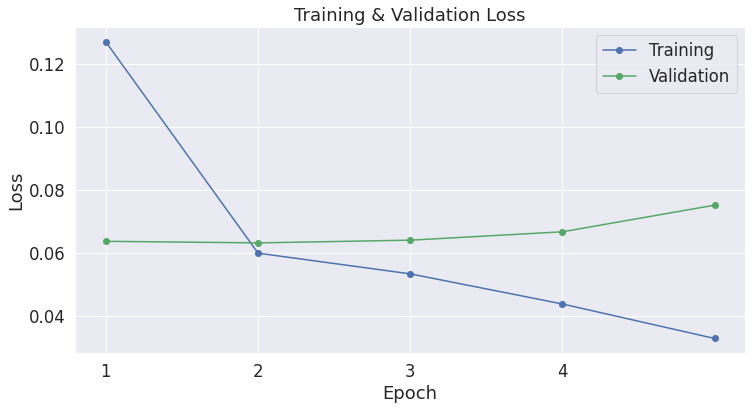

In [26]:
# Use plot styling from seaborn.
import seaborn as sns
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [27]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50259, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

In [28]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.json',
 './model_save/merges.txt',
 './model_save/added_tokens.json')

In [29]:
!ls -l --block-size=K ./model_save/

total 499888K
-rw-r--r-- 1 root root      1K Jan 24 22:19 added_tokens.json
-rw-r--r-- 1 root root      1K Jan 24 22:19 config.json
-rw-r--r-- 1 root root      1K Jan 24 22:19 generation_config.json
-rw-r--r-- 1 root root    446K Jan 24 22:19 merges.txt
-rw-r--r-- 1 root root 498442K Jan 24 22:19 pytorch_model.bin
-rw-r--r-- 1 root root      1K Jan 24 22:19 special_tokens_map.json
-rw-r--r-- 1 root root      1K Jan 24 22:19 tokenizer_config.json
-rw-r--r-- 1 root root    976K Jan 24 22:19 vocab.json


In [30]:
!ls -l --block-size=M ./model_save/pytorch_model.bin

-rw-r--r-- 1 root root 487M Jan 24 22:19 ./model_save/pytorch_model.bin


In [31]:
# Copy the model files to a directory in your Google Drive.
!cp -r ./model_save/ $data_dir

# # Load a trained model and vocabulary that you have fine-tuned
#model = GPT2LMHeadModel.from_pretrained(output_dir)
#tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
#model.to(device)

cp: missing destination file operand after './model_save/'
Try 'cp --help' for more information.


In [1]:
model.eval()

prompt = "<|startoftext|>Character: Michael"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated, 
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

NameError: ignored